# Projeto ADC

## Imports

In [2]:
import networkx as nx
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import numpy as np
import math

## 1. Subsetting
### 1.1 Creating subset
- Community sampling
- Pagerank sampling
- Snowball sampling
- BFS sampling
- Random walk sampling
- Remove nodes without communities
- Remove isolated nodes
### 1.2 Saving subset
Save subset using pickle to keep data consistent across environments

In [2]:
def load_graph_from_edgelist(filepath):
    G = nx.Graph()
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    for to_node in parts[1:]:
                        G.add_edge(parts[0], to_node)
            except ValueError:
                continue
    
    return G

def load_communities(filepath, min_size=3):
    communities = {}
    with open(filepath, 'r') as file:
        for idx, line in enumerate(file):
            if line.strip():
                community = list(map(int, line.strip().split()))
                if len(community) >= min_size:
                    communities[idx + 1] = community
    return communities

graph_filepath = 'com-youtube.ungraph.txt'
community_filepath = 'com-youtube.all.cmty.txt'

G = load_graph_from_edgelist(graph_filepath)
communities = load_communities(community_filepath)

print(f"Número de comunidades: {len(communities)}")

# Ordenar as comunidades pelo tamanho
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]))

# Definir limites para escolher comunidades
MIN_NODES = 10
MAX_NODES = 50000

selected_nodes = set()
for community_id, nodes in sorted_communities:
    if MIN_NODES <= len(nodes) <= MAX_NODES:
        selected_nodes.update(nodes)
    if len(selected_nodes) >= MAX_NODES:
        break

subgraph = G.subgraph(selected_nodes).copy()

print(f"Número de nós no subgrafo inicial: {subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo inicial: {subgraph.number_of_edges()}")

if subgraph.number_of_nodes() > 0 and subgraph.number_of_edges() > 0:
    nx.write_edgelist(subgraph, 'subgraph.edgelist')
else:
    print("Nenhum subgrafo válido foi gerado. Verifique os parâmetros ou os dados.")

# Calcular métricas do subgrafo
subgraph_acc = nx.average_clustering(subgraph)
subgraph_degree_assortativity = nx.degree_assortativity_coefficient(subgraph)
subgraph_average_degree = sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes()
subgraph_density = nx.density(subgraph)
subgraph_diameter = nx.diameter(subgraph) if nx.is_connected(subgraph) else 'Subgrafo não conectado'

# Imprimir as métricas
print("Métricas do subgrafo inicial:")
print(f"  - Average Clustering Coefficient: {subgraph_acc}")
print(f"  - Degree Assortativity Coefficient: {subgraph_degree_assortativity}")
print(f"  - Average Degree: {subgraph_average_degree}")
print(f"  - Density: {subgraph_density}")
print(f"  - Diameter: {subgraph_diameter}")

subgraph_nodes = set(selected_nodes)  # Inicialmente contém os nós das comunidades selecionadas

# 2. Aplicar PageRank-based Sampling para selecionar nós importantes
def pagerank_sampling(graph, num_nodes=40000):
    pagerank_scores = nx.pagerank(graph)
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    return set(sorted_nodes[:num_nodes])

pagerank_nodes = pagerank_sampling(G, num_nodes=50000)
subgraph_nodes.update(pagerank_nodes)
print(f"Número de nós após PageRank Sampling: {len(subgraph_nodes)}")

# 3. Aplicar Snowball Sampling para expandir conexões entre comunidades
def snowball_sampling(graph, start_node, depth=2, max_nodes=30000):
    sampled_nodes = set([start_node])
    frontier = [start_node]
    
    while frontier and len(sampled_nodes) < max_nodes:
        new_frontier = []
        for node in frontier:
            neighbors = list(graph.neighbors(node))
            new_frontier.extend(neighbors)
            sampled_nodes.update(neighbors)
            if len(sampled_nodes) >= max_nodes:
                break
        frontier = new_frontier
    
    return sampled_nodes

# Selecionar nós na borda do subgrafo para iniciar Snowball Sampling
boundary_nodes = [node for node in subgraph_nodes if len(set(G.neighbors(node)) - subgraph_nodes) > 0]
selected_boundary_nodes = random.sample(boundary_nodes, min(10, len(boundary_nodes)))
snowball_nodes = set()
for node in selected_boundary_nodes:
    snowball_nodes.update(snowball_sampling(G, node, depth=2, max_nodes=20000))

# Adicionar nós do Snowball Sampling ao subgrafo
subgraph_nodes.update(snowball_nodes)
print(f"Número de nós após Snowball Sampling: {len(subgraph_nodes)}")

# 4. Aplicar BFS para garantir que a componente seja conectada
def bfs_sampling(graph, start_node, max_nodes=50000):
    visited = set([start_node])
    queue = [start_node]
    
    while queue and len(visited) < max_nodes:
        node = queue.pop(0)
        neighbors = list(graph.neighbors(node))
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= max_nodes:
                    break
    
    return visited

bfs_start_node = random.choice(list(subgraph_nodes))
bfs_nodes = bfs_sampling(G, bfs_start_node, max_nodes=80000)
subgraph_nodes.update(bfs_nodes)
print(f"Número de nós após BFS Sampling: {len(subgraph_nodes)}")

# 5. Aplicar Random Walk Sampling para garantir diversidade
def random_walk_sampling(graph, start_node, steps=200):
    sampled_nodes = set()
    current_node = start_node
    
    for _ in range(steps):
        neighbors = list(graph.neighbors(current_node))
        if neighbors:
            next_node = random.choice(neighbors)
            sampled_nodes.add(next_node)
            current_node = next_node
        else:
            break
    
    return sampled_nodes

initial_nodes = random.sample(list(subgraph_nodes), min(5, len(subgraph_nodes)))
random_walk_nodes = set()
for node in initial_nodes:
    random_walk_nodes.update(random_walk_sampling(G, node, steps=1000))

subgraph_nodes.update(random_walk_nodes)
print(f"Número de nós após Random Walk Sampling: {len(subgraph_nodes)}")

# Remover nós sem comunidades
nodes_with_communities = set()
for community in communities.values():
    nodes_with_communities.update(set(community))

subgraph_nodes = subgraph_nodes.intersection(nodes_with_communities)
print(f"Número de nós após remover nós sem comunidades: {len(subgraph_nodes)}")

# Criar grafo e remover nós isolados
final_subgraph = G.subgraph(subgraph_nodes).copy()

isolates = list(nx.isolates(final_subgraph))
final_subgraph.remove_nodes_from(isolates)

print(f"Número de nós após remover nós isolados: {final_subgraph.number_of_nodes()}")

print(f"Número de nós no subgrafo final: {final_subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo final: {final_subgraph.number_of_edges()}")

# Calcular métricas do subgrafo final
final_subgraph_acc = nx.average_clustering(final_subgraph)
final_subgraph_degree_assortativity = nx.degree_assortativity_coefficient(final_subgraph)
final_subgraph_average_degree = sum(dict(final_subgraph.degree()).values()) / final_subgraph.number_of_nodes()
final_subgraph_density = nx.density(final_subgraph)
final_subgraph_diameter = nx.diameter(final_subgraph) if nx.is_connected(final_subgraph) else 'Subgrafo não conectado'

print("Métricas do subgrafo final:")
print(f"  - Average Clustering Coefficient: {final_subgraph_acc}")
print(f"  - Degree Assortativity Coefficient: {final_subgraph_degree_assortativity}")
print(f"  - Average Degree: {final_subgraph_average_degree}")
print(f"  - Density: {final_subgraph_density}")
print(f"  - Diameter: {final_subgraph_diameter}")

# Salvar variáveis importantes usando pickle
with open('saved_data.pkl', 'wb') as f:
    pickle.dump({
        'G': G,
        'subgraph': subgraph,
        'final_subgraph': final_subgraph,
        'communities': communities,
        'sorted_communities': sorted_communities,
        'selected_nodes': selected_nodes,
        'subgraph_nodes': subgraph_nodes
    }, f)

print("Variáveis importantes foram salvas com sucesso usando pickle.")

Número de comunidades: 8385
Número de nós no subgrafo inicial: 37038
Número de arestas no subgrafo inicial: 254322
Métricas do subgrafo inicial:
  - Average Clustering Coefficient: 0.18641674982746945
  - Degree Assortativity Coefficient: -0.08037168526976746
  - Average Degree: 13.733030941195528
  - Density: 0.0003707922062044855
  - Diameter: Subgrafo não conectado
Número de nós após PageRank Sampling: 77155
Número de nós após Snowball Sampling: 137537
Número de nós após BFS Sampling: 163245
Número de nós após Random Walk Sampling: 164610
Número de nós após remover nós sem comunidades: 40533
Número de nós após remover nós isolados: 40410
Número de nós no subgrafo final: 40410
Número de arestas no subgrafo final: 285727
Métricas do subgrafo final:
  - Average Clustering Coefficient: 0.18078256497293288
  - Degree Assortativity Coefficient: -0.07216365953990506
  - Average Degree: 14.141400643405097
  - Density: 0.0003499567087382785
  - Diameter: Subgrafo não conectado
Variáveis impo

### 1.3 Loading subset
Load subset data from pickle file to keep data consistent across environments.

In [3]:
######## Outro bloco de código para carregar as variáveis e o subgrafo ########
# Carregar o subgrafo, as comunidades e a lista de nós salvos
with open('saved_data.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    
final_subgraph = saved_data['final_subgraph']
communities = saved_data['communities']
subgraph_nodes = saved_data['subgraph_nodes']
G = saved_data['G']

# Verificar o subgrafo carregado
print(f"Número de nós no subgrafo carregado: {final_subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo carregado: {final_subgraph.number_of_edges()}")


Número de nós no subgrafo carregado: 40410
Número de arestas no subgrafo carregado: 285727


Mapping nodes to their communities  

In [4]:
def map_nodes_to_communities(communities):
    node_to_communities = {}
    for community_id, nodes in communities.items():
        for node in nodes:
            if node not in node_to_communities:
                node_to_communities[node] = []
            node_to_communities[node].append(community_id)
    return node_to_communities

def add_communities_to_graph(graph, node_to_communities):
    for node, communities in node_to_communities.items():
        if graph.has_node(node):
            graph.nodes[node]['communities'] = communities

node_to_communities = map_nodes_to_communities(communities)
add_communities_to_graph(final_subgraph, node_to_communities)

## 2. Visualize subset

### 2.1 Create .gml file to load in Gephi

Added the 'community' field so we can color nodes by community in Gephi.

In [5]:
# export to gml
nx.write_gml(final_subgraph, "graph_with_communities.gml")


### 2.2 Show the PNG exported from Gephi

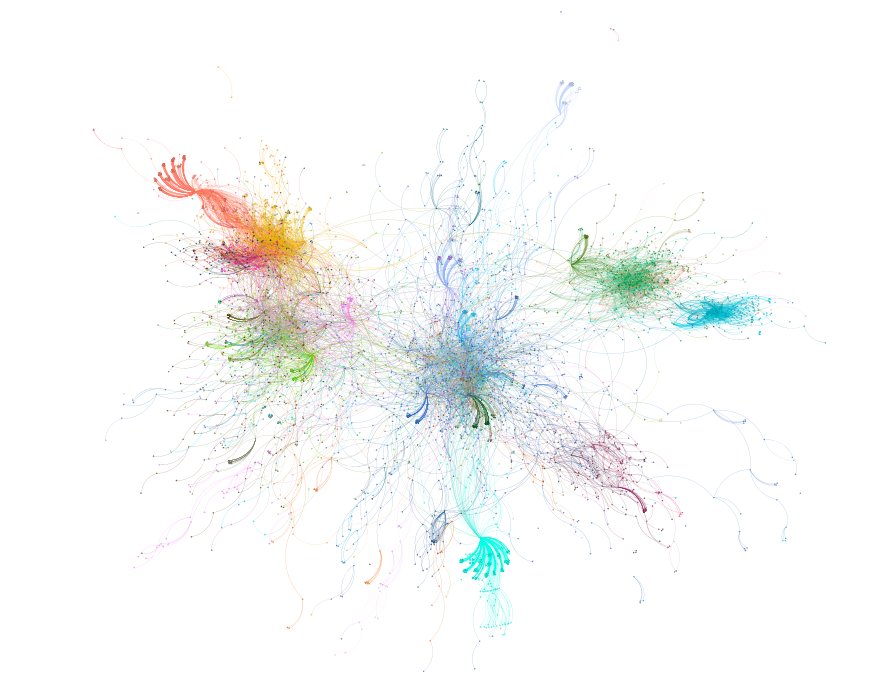

In [6]:
from IPython.display import Image, display

image_path = "graph_with_communities.png"

display(Image(filename=image_path))


## 3. Analyse subset

### 3.1 Compute community metrics
- Clustering
- Density
- Internal edge fraction

In [7]:
def compute_community_metrics(G, communities):
    metrics = []

    for (comm_number, community_nodes) in communities.items():  
        subgraph = G.subgraph(community_nodes)
        
        # ver se a comunidade é composta por nós isolados
        num_edges = subgraph.number_of_edges()
        
        if num_edges == 0:
            clustering = 0  
            density = 0     
            internal_edge_fraction = 0  
        else:
            # métricas
            clustering = nx.average_clustering(subgraph)
            density = nx.density(subgraph)
            internal_edges = num_edges
            total_edges = sum([G.degree(node) for node in community_nodes if node in G])
            internal_edge_fraction = internal_edges / total_edges if total_edges > 0 else 0
        
        metrics.append({
            "community_id": comm_number,
            "num_nodes": len(community_nodes),
            "clustering": clustering,
            "density": density,
            "internal_edge_fraction": internal_edge_fraction
        })

    return metrics

community_metrics = compute_community_metrics(final_subgraph, communities)


### 3.1.1 Compare results to full network
- The much higher clustering coefficient and density within the communities suggest that these regions of the network are more tightly knit compared to the full network. Nodes within these communities are more likely to have neighbors who are also neighbors of each other.

In [8]:
# compute cc and density for communities in the subgraph
subset_community_clustering = sum([m["clustering"] for m in community_metrics]) / len(community_metrics)
subset_community_density = sum([m["density"] for m in community_metrics]) / len(community_metrics)

# full network metrics (found at SNAP website)
full_clustering = 0.0808
full_density = nx.density(G)

print("Comparison of Metrics:")
print(f"Full Network Clustering Coefficient: {full_clustering}")
print(f"Subset Average Community Clustering Coefficient: {subset_community_clustering}")
print(f"Full Network Density: {full_density}")
print(f"Subset Average Community Density: {subset_community_density}")

Comparison of Metrics:
Full Network Clustering Coefficient: 0.0808
Subset Average Community Clustering Coefficient: 0.17615366127451623
Full Network Density: 4.639260713241579e-06
Subset Average Community Density: 0.4483950688177821


### 3.1.2 Visualize results
- Larger communities -> less cohesive and less dense 
- Smaller communities -> more cohesive and more dense

This suggests that larger communities are more spread out and have scarcer connections, probably due to being more diverse and having different levels of engagement within communities. <br>
This can also be due to bigger communities most likely being public, where anyone can join, meaning that nodes entering these communities might not have any friends (connections) within it. On the other hand, smaller communities are most likely private (invite only) meaning you would need someone to invite you in, most likely a friend, increasing connections within that community.


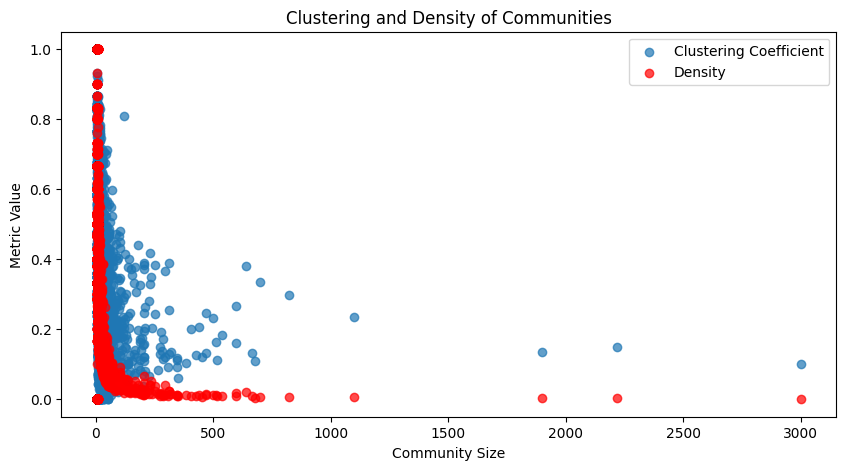

In [9]:
df = pd.DataFrame(community_metrics)


plt.figure(figsize=(10, 5))
plt.scatter(df["num_nodes"], df["clustering"], label="Clustering Coefficient", alpha=0.7)
plt.scatter(df["num_nodes"], df["density"], label="Density", alpha=0.7, color="red")
plt.xlabel("Community Size")
plt.ylabel("Metric Value")
plt.title("Clustering and Density of Communities")
plt.legend()
plt.show()


### 3.2 Measure node influence
- Degree centrality
- Betweenness centrality

In [10]:
def compute_node_influence(G):
    # compute centrality metrics
    degree_centrality = nx.degree_centrality(G)
    # k=500 to reduce computation time due to large amount of edges
    betweenness_centrality = nx.betweenness_centrality(G, k=500, seed=42) 


    return degree_centrality, betweenness_centrality

degree_centrality, betweenness_centrality = compute_node_influence(final_subgraph)

In [11]:
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)

print("Average Degree Centrality: ", avg_degree_centrality)
print("Average Betweenness Centrality: ", avg_betweenness_centrality)

Average Degree Centrality:  0.0003499567087384146
Average Betweenness Centrality:  7.578043362292641e-05


### 3.2.1 Visualize results
- A small number of nodes have significantly higher degree centrality, indicating the presence of hub nodes that are highly connected.
- A few nodes have disproportionately high betweenness centrality, meaning they play key roles in bridging different parts of the network.
- The log-log plot suggests a power-law distribution, characteristic of scale-free networks. This implies that the network might have a hierarchical structure with a few very influential nodes, possibly the users that create groups.

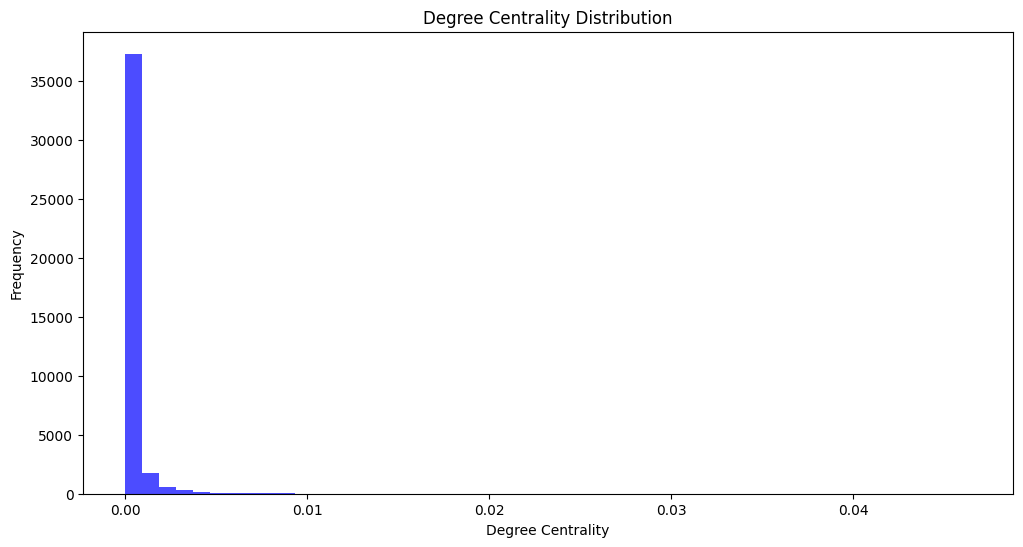

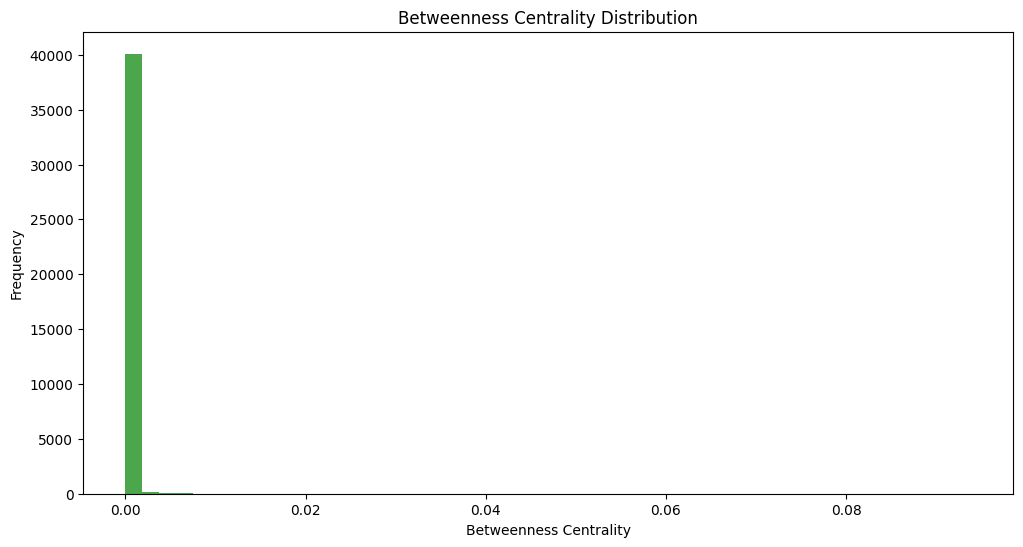

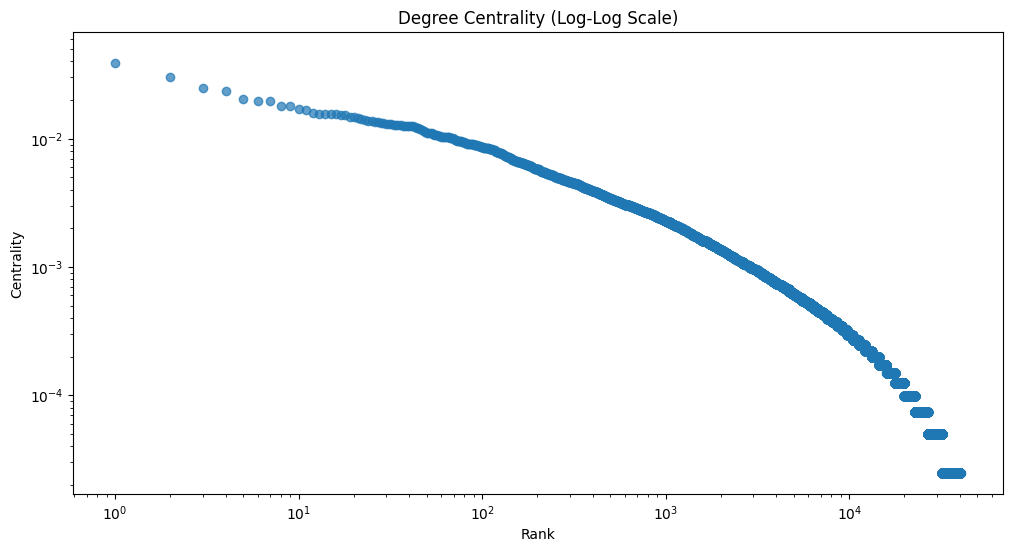

In [12]:
# degree centrality distribution
plt.figure(figsize=(12, 6))
plt.hist(list(degree_centrality.values()), bins=50, color='blue', alpha=0.7)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

# betweenness centrality distribution
plt.figure(figsize=(12, 6))
plt.hist(list(betweenness_centrality.values()), bins=50, color='green', alpha=0.7)
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()

# log-log degree centrality 
plt.figure(figsize=(12, 6))
degree_values = sorted(degree_centrality.values(), reverse=True)
plt.plot(range(len(degree_values)), degree_values, marker="o", linestyle="none", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.title("Degree Centrality (Log-Log Scale)")
plt.xlabel("Rank")
plt.ylabel("Centrality")
plt.show()

### 3.3 Measure influential nodes within communities

### 3.3.1 Rank communities
- By average degree centrality (tightly-knit hubs)
- By average betweenness centrality (brifges)

Community 2134 leads both rankings meaning it acts both as an important hub and an important bridge, suggesting its a key structural and functional element of the graph.

In [13]:
# avg centrality per community
def avg_community_centrality(communities, centrality):
    community_scores = defaultdict(list)
    for comm_id, nodes in communities.items():
        for node in nodes:
            if node in centrality:
                community_scores[comm_id].append(centrality[node])
    
    community_avg_scores = {comm_id: np.mean(scores) for comm_id, scores in community_scores.items() if scores}
    return community_avg_scores


avg_degree_centrality_by_comm = avg_community_centrality(communities, degree_centrality)
avg_betweenness_centrality_by_comm = avg_community_centrality(communities, betweenness_centrality)

# sort by avg score
top_degree_centrality_communities = sorted(avg_degree_centrality_by_comm.items(), key=lambda x: -x[1])[:10]
top_betweenness_centrality_communities = sorted(avg_betweenness_centrality_by_comm.items(), key=lambda x: -x[1])[:10]

print("Top 10 communities by average degree centrality:")
for comm_id, avg_score in top_degree_centrality_communities:
    print(f"Community {comm_id}: {avg_score:.4f}")

print("\nTop 10 communities by average betweenness centrality:")
for comm_id, avg_score in top_betweenness_centrality_communities:
    print(f"Community {comm_id}: {avg_score:.4f}")


Top 10 communities by average degree centrality:
Community 2134: 0.0170
Community 4265: 0.0152
Community 4266: 0.0148
Community 2154: 0.0128
Community 2144: 0.0125
Community 2119: 0.0119
Community 2127: 0.0115
Community 2145: 0.0114
Community 2128: 0.0105
Community 2139: 0.0104

Top 10 communities by average betweenness centrality:
Community 2134: 0.0152
Community 4265: 0.0141
Community 4266: 0.0139
Community 1607: 0.0124
Community 2292: 0.0113
Community 2144: 0.0112
Community 2119: 0.0111
Community 2154: 0.0106
Community 8662: 0.0101
Community 1590: 0.0091


### 3.3.2 Rank nodes by influence

In [14]:
# sort
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: -x[1])[:10]
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: -x[1])[:10]

#top nodes with community
print("Top 10 nodes by degree centrality: \n")
for node, centrality in top_degree_nodes:
    print(f"Node {node} (Degree Centrality: {centrality:.4f}) belongs to communities: {node_to_communities.get(node, 'None')}")

print("\nTop 10 nodes by betweenness centrality: \n")
for node, centrality in top_betweenness_nodes:
    print(f"Node {node} (Betweenness Centrality: {centrality:.4f}) belongs to communities: {node_to_communities.get(node, 'None')}")


Top 10 nodes by degree centrality: 

Node 1846 (Degree Centrality: 0.0465) belongs to communities: [176, 442, 3372, 3468, 4129, 4263, 4264, 4265, 4266, 4268, 4269, 4270, 4271, 4273, 4274, 4277]
Node 311 (Degree Centrality: 0.0390) belongs to communities: [176, 268, 485, 552, 701, 944, 1004, 1065, 1081, 1151, 1188, 1770, 2091, 2092, 2095, 2096, 2098, 2099, 2101, 2102, 2103, 2105, 2106, 2107, 2108, 2111, 2112, 2113, 2114, 2116, 2117, 2118, 2119, 2120, 2121, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159]
Node 2526 (Degree Centrality: 0.0303) belongs to communities: [435, 437, 2325, 4274, 4929, 5202, 5203]
Node 617 (Degree Centrality: 0.0249) belongs to communities: [176, 485, 701, 944, 1004, 1081, 1446, 2095, 2105, 2111, 2112, 2114, 2116, 2124, 2125, 2126, 2127, 2128, 2129, 2135, 2136, 2139, 2143, 2145, 2147, 2153, 2154, 2155, 2

#### Compare community structures

In [15]:
def community_density(G, community):
    subgraph = G.subgraph(community)
    num_edges = subgraph.number_of_edges()
    num_nodes = len(community)
    

    max_edges = num_nodes * (num_nodes - 1) / 2
    if max_edges == 0:
        return 0 
    return num_edges / max_edges


def compare_nodes_with_community_density(G, communities, degree_centrality, betweenness_centrality):
    high_degree_in_dense_community = []
    high_betweenness_in_sparse_community = []
    
    for community_id, community in communities.items():
        density = community_density(G, community)
        
        for node in community:
            # check if node has high degree or betweenness
            high_degree_threshold = degree_centrality.get(node, 0) > 0.02  
            high_betweenness_threshold = betweenness_centrality.get(node, 0) > 0.02  
            
            # look for high-degree nodes in dense communities
            if high_degree_threshold and density > 0.5:  # threshold for dense community
                high_degree_in_dense_community.append((node, community_id, density))
            
            # look for high-betweenness nodes in sparse communities
            if high_betweenness_threshold and density < 0.01:  # threshold for sparse community
                high_betweenness_in_sparse_community.append((node, community_id, density))
    
    return high_degree_in_dense_community, high_betweenness_in_sparse_community

high_degree_in_dense_community, high_betweenness_in_sparse_community = compare_nodes_with_community_density(final_subgraph, communities, degree_centrality, betweenness_centrality)
print("High Degree Nodes in Dense Communities:\n")
for node, comm, density in high_degree_in_dense_community:
    print(f"Node {node} in Community {comm} (Density: {density:.4f})")

print("\nHigh Betweenness Nodes in Sparse Communities:\n")
for node, comm, density in high_betweenness_in_sparse_community:
    print(f"Node {node} in Community {comm} (Density: {density:.4f})")

High Degree Nodes in Dense Communities:

Node 311 in Community 2119 (Density: 0.8333)
Node 311 in Community 2125 (Density: 0.6667)
Node 617 in Community 2125 (Density: 0.6667)
Node 311 in Community 2127 (Density: 0.7143)
Node 617 in Community 2127 (Density: 0.7143)
Node 311 in Community 2128 (Density: 0.5278)
Node 617 in Community 2128 (Density: 0.5278)
Node 311 in Community 2131 (Density: 0.7333)
Node 311 in Community 2140 (Density: 0.5455)
Node 311 in Community 2144 (Density: 0.8333)
Node 311 in Community 2145 (Density: 0.6667)
Node 617 in Community 2145 (Density: 0.6667)
Node 617 in Community 2564 (Density: 0.6667)
Node 617 in Community 2577 (Density: 0.6667)
Node 617 in Community 2581 (Density: 0.6000)
Node 1846 in Community 4265 (Density: 0.6667)
Node 1846 in Community 4266 (Density: 0.6667)

High Betweenness Nodes in Sparse Communities:

Node 210 in Community 86 (Density: 0.0079)
Node 1491 in Community 86 (Density: 0.0079)
Node 311 in Community 176 (Density: 0.0037)
Node 1846 in 

#### Analyze Overlap Between Communities
- Large communities attract users with diverse interests, potentially leading to overlaps with other groups. For example, a popular group focused on general topics like "music" or "gaming" might intersect with niche communities focused on specific genres or games.
- Larger groups may be more central in the network. Users in these groups may act as bridges connecting smaller, specialized groups, leading to more overlap between their memberships.

In [6]:
def analyze_community_overlap(communities, node_to_communities):
    overlap_data = defaultdict(list)
    for node, comms in node_to_communities.items():
        if len(comms) > 1:  # Nó está em múltiplas comunidades
            for i in range(len(comms)):
                for j in range(i + 1, len(comms)):
                    overlap_data[(comms[i], comms[j])].append(node)
    
    overlap_summary = []
    for (comm_a, comm_b), nodes in overlap_data.items():
        overlap_summary.append({
            "Community A": comm_a,
            "Community B": comm_b,
            "Shared Nodes": len(nodes),
            "Overlap Fraction": len(nodes) / min(len(communities[comm_a]), len(communities[comm_b]))
        })
    
    return pd.DataFrame(overlap_summary).sort_values(by="Shared Nodes", ascending=False)

# Analyze overlaps
community_overlap_df = analyze_community_overlap(communities, node_to_communities)

In [17]:
community_overlap_df.to_csv("community_overlap_analysis.csv", index=False)
print("Community Overlap Analysis saved as 'community_overlap_analysis.csv'.")
#print(community_overlap_df.head())

Community Overlap Analysis saved as 'community_overlap_analysis.csv'.


The 10 pairs of communities with the most overlap

In [7]:
print(community_overlap_df.head(10))

       Community A  Community B  Shared Nodes  Overlap Fraction
228            176          944           848          0.446316
814            944         1168           348          0.316940
787            176         1168           337          0.306922
261            268          977           257          0.311893
753            109          120           246          0.494970
13356          176         1081           246          0.526767
780            120          977           201          0.375701
1962           944         1065           199          0.388672
238            268          483           192          0.666667
200            165          977           188          0.429224


The most overlap happens between the largest communities in the network, suggesting 

In [8]:
print(f"Size of community 944: {len(communities[944])}")
print(f"Size of community 977: {len(communities[977])}")
print(f"Size of community 176: {len(communities[176])}")

Size of community 944: 1900
Size of community 977: 824
Size of community 176: 2217


#### Central and Peripheral Communities

In [26]:
#### Central and Peripheral Communities
def categorize_communities_by_structure(graph, communities):
    community_metrics = []
    for comm_id, nodes in communities.items():
        subgraph = graph.subgraph(nodes)
        if len(nodes) > 1 and subgraph.number_of_edges() > 0:  # Ignoring invalid communities
            density = nx.density(subgraph)
            clustering = nx.average_clustering(subgraph)
        else:
            density = 0  # Communities without edges have a density of 0
            clustering = 0  # Communities without edges or with only 1 node have a clustering coefficient of 0
        community_metrics.append({
            "Community ID": comm_id,
            "Density": density,
            "Clustering": clustering,
            "Size": len(nodes),
        })
    
    df = pd.DataFrame(community_metrics)
    central = df[(df["Density"] > 0.5) & (df["Clustering"] > 0.5)]["Community ID"].tolist()
    peripheral = df[(df["Density"] <= 0.5) & (df["Clustering"] <= 0.5)]["Community ID"].tolist()
    
    return df, central, peripheral

# Identify central and peripheral communities
community_metrics_df, central_communities, peripheral_communities = categorize_communities_by_structure(final_subgraph, communities)

In [29]:
community_metrics_df.to_csv("community_metrics.csv", index=False)
print("Community Metrics saved as 'community_metrics.csv'.")

Community Metrics saved as 'community_metrics.csv'.


#### Influential Nodes: Theoretical Proposals

In [22]:
def analyze_influential_nodes(top_degree_nodes, top_betweenness_nodes, node_to_communities):
    theories = []
    for node, centrality in top_degree_nodes:
        theories.append({
            "Node": node,
            "Metric": "Degree Centrality",
            "Value": centrality,
            "Communities": node_to_communities.get(node, []),
            #"Theory": "Possibly a content creator or an active user with multiple connections"
        })
    
    for node, centrality in top_betweenness_nodes:
        theories.append({
            "Node": node,
            "Metric": "Betweenness Centrality",
            "Value": centrality,
            "Communities": node_to_communities.get(node, []),
            #"Theory": "Possibly a connector between different communities"
        })
    
    return pd.DataFrame(theories)

# Generate theories about influential nodes
influential_theories_df = analyze_influential_nodes(top_degree_nodes, top_betweenness_nodes, node_to_communities)

In [23]:
# Salvar resultados
influential_theories_df.to_csv("influential_node_theories.csv", index=False)
print("Influential Node Theories saved as 'influential_node_theories.csv'.")
#print(influential_theories_df.head())

Influential Node Theories saved as 'influential_node_theories.csv'.


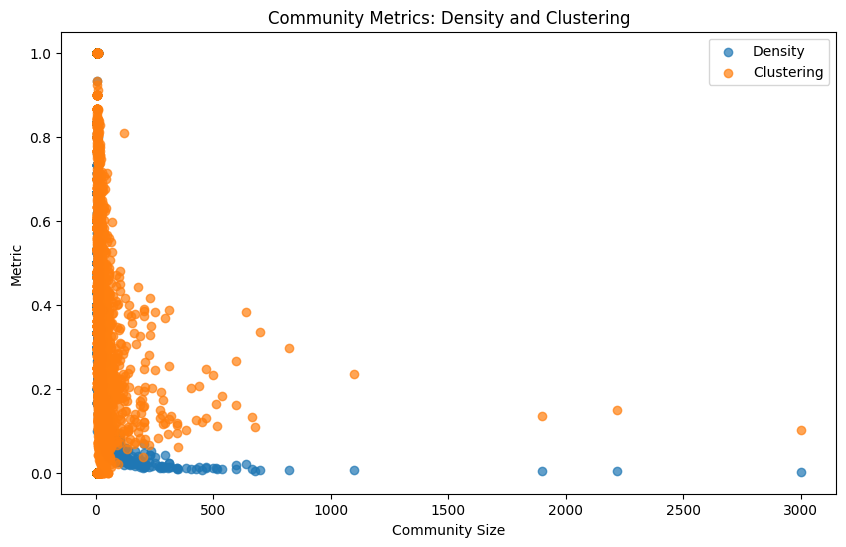

In [24]:
# Visualizar métricas das comunidades
def plot_community_metrics(community_metrics_df):
    plt.figure(figsize=(10, 6))
    plt.scatter(community_metrics_df["Size"], community_metrics_df["Density"], alpha=0.7, label="Density")
    plt.scatter(community_metrics_df["Size"], community_metrics_df["Clustering"], alpha=0.7, label="Clustering")
    plt.xlabel("Community Size")
    plt.ylabel("Metric")
    plt.legend()
    plt.title("Community Metrics: Density and Clustering")
    plt.show()

plot_community_metrics(community_metrics_df)

### Compute centrality metrics
Using igraph because its faster

In [5]:
degree_centrality = nx.degree_centrality(final_subgraph)

0.38 -> Moderatly positive correlation <br>
This means that nodes that belong to more communities tend to have more connections, on average. These users probably act as bridges or hubs. Nodes with high overlap play a key role in spreading information/connecting parts of the network meaning they are important for inter-group interactions.

                   overlap  degree_centrality
overlap            1.00000            0.37851
degree_centrality  0.37851            1.00000


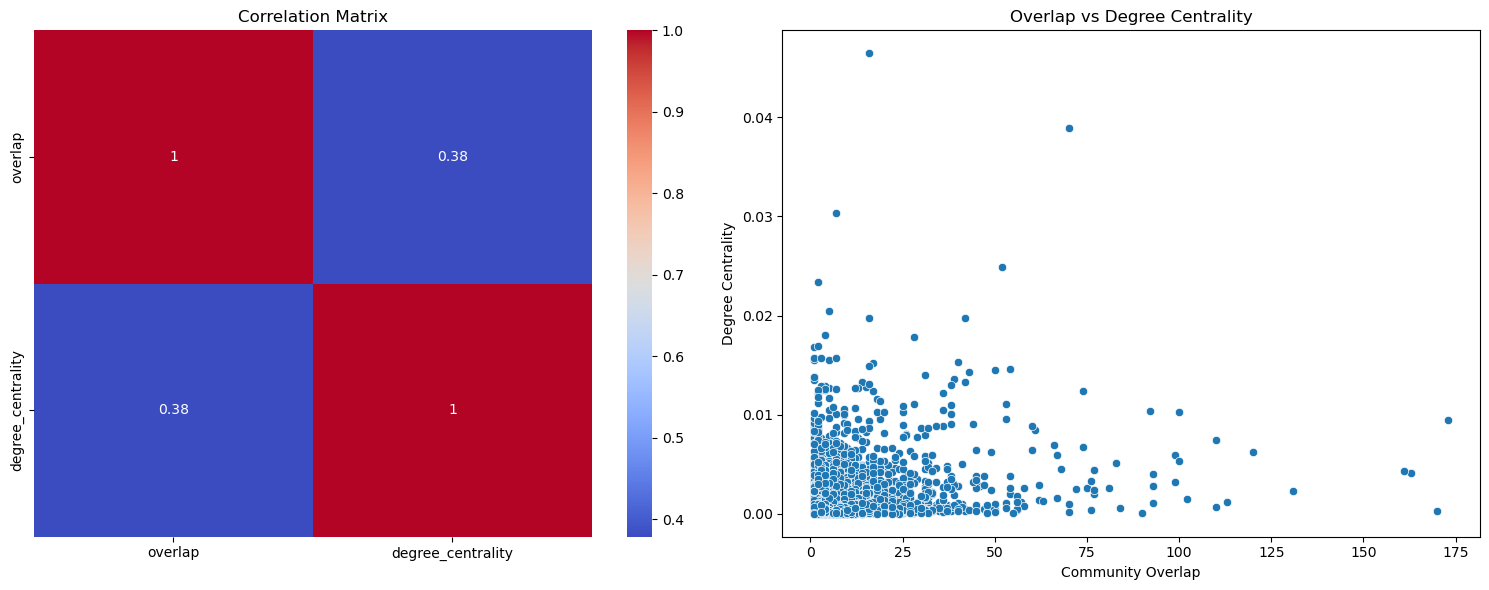

In [9]:
import seaborn as sns

# transform node_to_communities to store numerical values instead of lists
node_to_overlap = {node: len(communities) for node, communities in node_to_communities.items()}


df = pd.DataFrame({
    'overlap': pd.Series(node_to_overlap),
    'degree_centrality': pd.Series(degree_centrality),
})

# Compute correlation
correlation = df.corr()
print(correlation)


fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the heatmap on the first subplot
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix')

# Plot the scatter plot on the second subplot
sns.scatterplot(data=df, x='overlap', y='degree_centrality', ax=axes[1])
axes[1].set_title('Overlap vs Degree Centrality')
axes[1].set_xlabel('Community Overlap')
axes[1].set_ylabel('Degree Centrality')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### Computing more expensive centrality metrics using a random samples of nodes

In [23]:
NUM_NODES = 5000  # Number of nodes to sample per iteration
NUM_SAMPLES = 10  # Number of repeated samplings

def compute_centrality_measures(graph, sampled_nodes):
    subgraph = graph.subgraph(sampled_nodes)
    
    betweenness = nx.betweenness_centrality(subgraph)
    try:
        eigenvector = nx.eigenvector_centrality(subgraph, max_iter=1000, tol=1e-6)
    except nx.PowerIterationFailedConvergence:
        print("Eigenvector centrality did not converge for this subgraph.")
        eigenvector = {node: None for node in subgraph.nodes}
    
    centrality_df = pd.DataFrame({
        'betweenness_centrality': pd.Series(betweenness),
        'eigenvector_centrality': pd.Series(eigenvector)
    })
    return centrality_df

all_results = []

# Perform repeated sampling
for i in range(NUM_SAMPLES):
    print(f"Running sample {i + 1}/{NUM_SAMPLES}...")
    
    # Sample nodes randomly
    sampled_nodes = random.sample(list(G.nodes), NUM_NODES)
    
    # Compute centrality measures for the sampled subgraph
    centrality_df = compute_centrality_measures(G, sampled_nodes)
    centrality_df['sample_iteration'] = i  
    all_results.append(centrality_df)


results_df = pd.concat(all_results)


aggregated_results = results_df.groupby(results_df.index).mean()


Running sample 1/10...
Running sample 2/10...
Running sample 3/10...
Running sample 4/10...
Running sample 5/10...
Running sample 6/10...
Running sample 7/10...
Running sample 8/10...
Running sample 9/10...
Running sample 10/10...


### Overlap vs Eigenvector centrality
- Low Overlap, High Eigenvector Centrality: These nodes might be hubs in specific groups with strong connections to influential members but are not spread across many groups.
- High Overlap, Low Eigenvector Centrality: Nodes with high overlap belong to multiple groups but are likely not well-connected to influential nodes. They may play more peripheral or bridging roles.<br>
The absence of nodes with both high eigenvector centrality and high overlap suggests that being central in terms of influence does not correlate with membership in many communities.

### Degree centrality vs Eigenvector centrality
- Low Degree, High Eigenvector Centrality: These nodes are highly influential, likely because they connect to other influential nodes, even with relatively few direct connections.
- High Degree, High Eigenvector Centrality: These nodes are both well-connected (high degree) and influential, suggesting they might be central hubs in their groups.
- High Degree, Low Eigenvector Centrality: These nodes have many connections but are not necessarily connected to influential nodes. They might be part of dense local neighborhoods or peripheral communities.

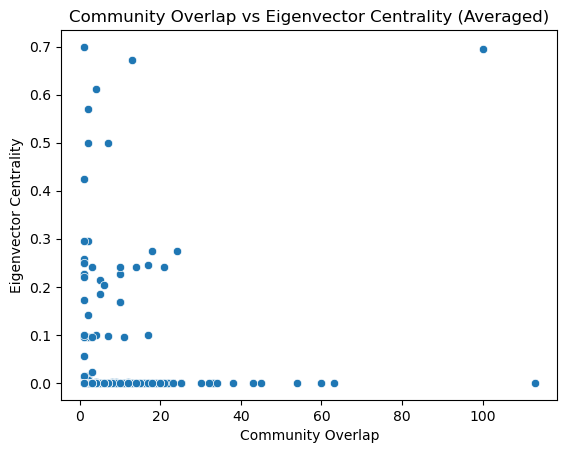

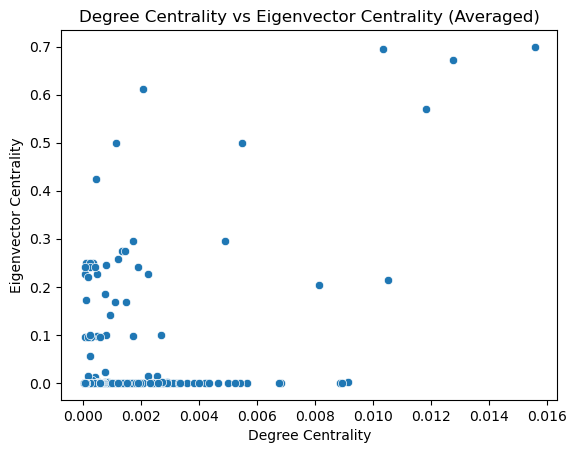

In [24]:
aggregated_results['degree_centrality'] = aggregated_results.index.map(degree_centrality)
aggregated_results['overlap'] = aggregated_results.index.map(node_to_overlap)

# Scatter plot: Eigenvector Centrality vs Overlap
sns.scatterplot(data=aggregated_results, x='overlap', y='eigenvector_centrality')
plt.title('Community Overlap vs Eigenvector Centrality (Averaged)')
plt.xlabel('Community Overlap')
plt.ylabel('Eigenvector Centrality')
plt.show()

# Scatter plot: Degree Centrality vs Eigenvector Centrality
sns.scatterplot(data=aggregated_results, x='degree_centrality', y='eigenvector_centrality')
plt.title('Degree Centrality vs Eigenvector Centrality (Averaged)')
plt.xlabel('Degree Centrality')
plt.ylabel('Eigenvector Centrality')
plt.show()

### Compute modularity accounting for overlap

In [38]:
def compute_modularity_overlapping(G, node_to_communities):
    m = G.size()
    modularity = 0.0

    for u, v in G.edges():
        com_u = set(node_to_communities.get(u, []))
        com_v = set(node_to_communities.get(v, []))
        
        if com_u and com_v: 
            overlap = len(com_u & com_v) / len(com_u | com_v)
        else:
            overlap = 0
        
        k_u = G.degree(u)
        k_v = G.degree(v)
        expected_weight = (k_u * k_v) / (2 * m)
        modularity += (1 - expected_weight) * overlap

    return modularity / (2 * m)

In [39]:
modularity = compute_modularity_overlapping(final_subgraph, node_to_communities)

In [40]:
print(f"Modularity: {modularity:.4f}")

Modularity: 0.0511


### Assortativity

In [ ]:
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# check if more overlap leads to more probability of connection
def analyze_community_overlap(G, community_dict):
    # originally sampled nodes but we can use all nodes 
    sampled_nodes = list(G.nodes())
    
    community_overlaps = []
    connections = []
    
    # compute overlap and connections between pairs
    for i in range(len(sampled_nodes)):
        for j in range(i+1, len(sampled_nodes)):
            node1 = sampled_nodes[i]
            node2 = sampled_nodes[j]
            
            communities1 = set(community_dict.get(node1, []))
            communities2 = set(community_dict.get(node2, []))
            overlap = len(communities1.intersection(communities2))

            is_connected = G.has_edge(node1, node2)
      
            community_overlaps.append(overlap)
            connections.append(is_connected)
    
    # convert no np arrays
    community_overlaps = np.array(community_overlaps).reshape(-1, 1)
    connections = np.array(connections)
    
    # Compute point-biserial correlation
    correlation, p_value = pointbiserialr(connections, community_overlaps.ravel())
    
    # Logistic Regression
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(community_overlaps)
    
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_scaled, connections)
    
    # Modify the visualization part to handle the data correctly
    plt.figure(figsize=(10, 6))
    plt.boxplot([
        community_overlaps[connections == False].ravel(),
        community_overlaps[connections == True].ravel()
    ], labels=['Not Connected', 'Connected'])
    plt.title('Community Overlap for Connected vs Non-Connected Nodes')
    plt.ylabel('Number of Shared Communities')
    plt.show()
    
    # Prepare results
    analysis_results = {
        'correlation': correlation,
        'p_value': p_value,
        'logistic_regression_coef': log_reg.coef_[0][0],
        'logistic_regression_intercept': log_reg.intercept_[0],
    }
    
    # Print results
    print("Analysis Results:")
    for key, value in analysis_results.items():
        print(f"{key}: {value}")
    
    return analysis_results



results = analyze_community_overlap(final_subgraph, communities)

MemoryError: Unable to allocate 6.08 GiB for an array with shape (816463845,) and data type float64

Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5


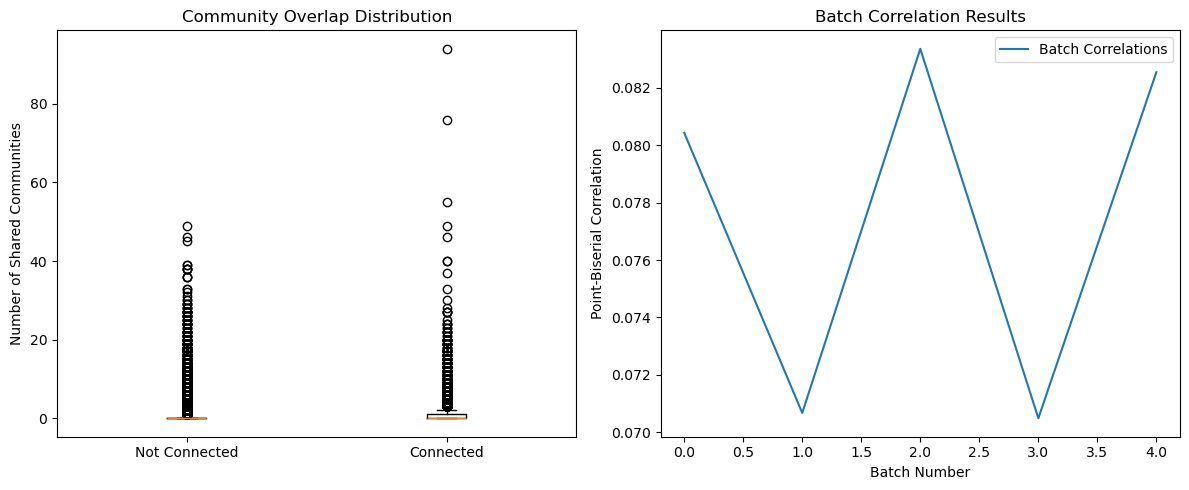

avg_correlation: 0.0774988069682582
correlation_std: 0.005725721347870149
avg_logistic_coef: 0.19264004952726704
logistic_coef_std: 0.012799724988107853


In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def batch_community_overlap_analysis_with_averaging(G, community_dict, batch_size=10000, num_batches=10):
    batch_correlations = []
    batch_logistic_coeffs = []
    batch_overlaps_by_connection = {
        'connected': [],
        'not_connected': []
    }
    
    # process each batch
    for batch in range(num_batches):
        sampled_nodes = random.sample(list(G.nodes()), batch_size)
        # track values for this batch
        all_overlaps = []
        all_connections = []
        
        for i in range(len(sampled_nodes)):
            for j in range(i+1, len(sampled_nodes)):
                node1 = sampled_nodes[i]
                node2 = sampled_nodes[j]
                
                # compute overlap
                communities1 = set(community_dict.get(node1, []))
                communities2 = set(community_dict.get(node2, []))
                overlap = len(communities1.intersection(communities2))
                
                # check connection
                is_connected = G.has_edge(node1, node2)
                
                all_overlaps.append(overlap)
                all_connections.append(is_connected)
        
        # convert to arrays
        overlaps_array = np.array(all_overlaps)
        connections_array = np.array(all_connections)
        
        # get correlation for the batch
        correlation, p_value = pointbiserialr(connections_array, overlaps_array)
        batch_correlations.append(correlation)
        
        # get logistic regression coefficient
        X = overlaps_array.reshape(-1, 1)
        y = connections_array
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        log_reg = LogisticRegression(max_iter=1000)
        log_reg.fit(X_scaled, y)
        batch_logistic_coeffs.append(log_reg.coef_[0][0])
        
        # store overlaps by connection type
        batch_overlaps_by_connection['connected'].append(
            overlaps_array[connections_array].tolist()
        )
        batch_overlaps_by_connection['not_connected'].append(
            overlaps_array[~connections_array].tolist()
        )
        
        print(f"Processed batch {batch + 1}")
    
    plt.figure(figsize=(12, 5))
    
    # 'unify' and plot data
    plt.subplot(1, 2, 1)
    connected_overlaps = [item for sublist in batch_overlaps_by_connection['connected'] for item in sublist]
    not_connected_overlaps = [item for sublist in batch_overlaps_by_connection['not_connected'] for item in sublist]
    
    plt.boxplot([not_connected_overlaps, connected_overlaps], 
                labels=['Not Connected', 'Connected'])
    plt.title('Community Overlap Distribution')
    plt.ylabel('Number of Shared Communities')
    
    # batch results for debug and analysis
    plt.subplot(1, 2, 2)
    plt.plot(batch_correlations, label='Batch Correlations')
    plt.title('Batch Correlation Results')
    plt.xlabel('Batch Number')
    plt.ylabel('Point-Biserial Correlation')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # get averages
    results = {
        'avg_correlation': np.mean(batch_correlations),
        'correlation_std': np.std(batch_correlations),
        'avg_logistic_coef': np.mean(batch_logistic_coeffs),
        'logistic_coef_std': np.std(batch_logistic_coeffs)
    }
    
    for key, value in results.items():
        print(f"{key}: {value}")
    
    return results

results = batch_community_overlap_analysis_with_averaging(final_subgraph, node_to_communities, batch_size=10000, num_batches=5)